# Histogrammes des Orientations du Gradient

In [14]:
pip install opencv-python-headless numpy matplotlib tqdm scikit-image scikit_learn seaborn


[notice] A new release of pip is available: 25.0.1 -> 26.0
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


## Data Loading

In [15]:
import cv2
import numpy as np 
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
import random
import pandas as pd
import torchvision.models as models
import torch 
import torch.nn as nn
from PIL import Image


from skimage.feature import hog
from skimage import data, exposure
import sklearn
from sklearn.metrics import classification_report
import seaborn as sns

from copy import deepcopy
import random

In [16]:
data_root_path = "data/UCF-101"

CLASS_NAMES = sorted(os.listdir(data_root_path))
if '.DS_Store' in CLASS_NAMES:
    CLASS_NAMES.remove('.DS_Store')
NUM_CLASSES = len(CLASS_NAMES)
print(f"Number of classes: {NUM_CLASSES}")

Number of classes: 5


## Folder Structure

In [5]:
!tree -d

.
└── data
    └── UCF-101
        ├── Biking
        ├── HandstandPushups
        ├── PlayingCello
        ├── PlayingViolin
        └── PushUps

8 directories


In [17]:
## Function to extract frames from a video file
def extract_all_frames_from_video(video_path, frame_rate=3):
    frames = []
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print(f"Error opening video file: {video_path}")
        return frames

    fps = cap.get(cv2.CAP_PROP_FPS)
    frame_interval = int(fps / frame_rate)

    frame_count = 0
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        if frame_count % frame_interval == 0:
            frames.append(frame)
        frame_count += 1

    cap.release()
    return frames

## Function to split the video into reference and test sets
# Added seed for reproducibility and to prevent data leaks when re-running cells
def create_reference_and_test_path_sets(data_root_path, reference_ratio=0.75, seed=42):
    reference_set = {}
    test_set = {}
    
    # Set seed for reproducible splits
    random.seed(seed)
    
    for class_name in CLASS_NAMES:
        class_path = os.path.join(data_root_path, class_name)
        video_files = [f for f in os.listdir(class_path) if f.endswith('.avi')]
        
        groups = set()
        for f in video_files:
            parts = f.split('_')
            for part in parts:
                if part.startswith('g') and len(part) == 3 and part[1:].isdigit():
                    groups.add(part)
        
        groups = list(groups)
        random.shuffle(groups)
        
        split_index = int(len(groups) * reference_ratio)
        ref_groups = set(groups[:split_index])
        test_groups = set(groups[split_index:])
        
        reference_set[class_name] = []
        test_set[class_name] = []
        
        for f in video_files:
            file_group = None
            parts = f.split('_')
            for part in parts:
                if part.startswith('g') and len(part) == 3 and part[1:].isdigit():
                    file_group = part
                    break
            
            full_path = os.path.join(class_path, f)
            
            if file_group in ref_groups:
                reference_set[class_name].append(full_path)
            elif file_group in test_groups:
                test_set[class_name].append(full_path)
                
    return reference_set, test_set

## Function to extract the frames from all videos in list of set video paths
def extract_frames_from_video_set(video_path_set, frame_rate=3):
    dataset_frames = {}
    dataset_manifest = {}
    for class_name, video_paths in tqdm(video_path_set.items(), desc="Processing classes"):
        dataset_frames[class_name] = []
        dataset_manifest[class_name] = []
        for video_path in tqdm(video_paths, desc=f"Processing videos in {class_name}", leave=False):
            frames = extract_all_frames_from_video(video_path, frame_rate)
            dataset_frames[class_name].extend(frames)
            dataset_manifest[class_name].append(len(frames))
    return dataset_frames, dataset_manifest

In [110]:
## using the videos in the data root, we compute some stats about the videos: number of frames, video length, frame size, etc
def compute_video_stats(data_root_path):
    stats = {}
    for class_name in tqdm(CLASS_NAMES, desc="Computing video stats for classes"):
        class_path = os.path.join(data_root_path, class_name)
        video_files = [f for f in os.listdir(class_path) if f.endswith('.avi')]
        num_videos = len(video_files)
        total_frames = 0
        frames = []
        for video_file in tqdm(video_files, desc=f"Processing videos in {class_name}", leave=False):
            video_path = os.path.join(class_path, video_file)
            video_frames = extract_all_frames_from_video(video_path, frame_rate=5)
            total_frames += len(video_frames)
            frames.append(video_frames)
        stats[class_name] = {
            "num_videos": num_videos,
            "total_frames": total_frames,
            "avg_frames_per_video": total_frames / num_videos,
            "min_frames_per_video": min([len(frames) for frames in frames]),
            "max_frames_per_video": max([len(frames) for frames in frames]),
            "avg_frame_size": np.mean([frame.shape for frames in frames for frame in frames], axis=0),
            "min_frame_size": np.min([frame.shape for frames in frames for frame in frames], axis=0),
            "max_frame_size": np.max([frame.shape for frames in frames for frame in frames], axis=0),
            "avg_video_length_sec": np.mean([len(frames)/5 for frames in frames]),
            "min_video_length_sec": min([len(frames)/5 for frames in frames]),
            "max_video_length_sec": max([len(frames)/5 for frames in frames]),
        }
    return stats

compute_video_stats(data_root_path)

Computing video stats for classes: 100%|██████████| 5/5 [00:13<00:00,  2.69s/it]


{'Biking': {'num_videos': 134,
  'total_frames': 6109,
  'avg_frames_per_video': 45.58955223880597,
  'min_frames_per_video': 21,
  'max_frames_per_video': 120,
  'avg_frame_size': array([240., 320.,   3.]),
  'min_frame_size': array([240, 320,   3]),
  'max_frame_size': array([240, 320,   3]),
  'avg_video_length_sec': np.float64(9.117910447761194),
  'min_video_length_sec': 4.2,
  'max_video_length_sec': 24.0},
 'HandstandPushups': {'num_videos': 128,
  'total_frames': 3007,
  'avg_frames_per_video': 23.4921875,
  'min_frames_per_video': 10,
  'max_frames_per_video': 51,
  'avg_frame_size': array([240., 320.,   3.]),
  'min_frame_size': array([240, 320,   3]),
  'max_frame_size': array([240, 320,   3]),
  'avg_video_length_sec': np.float64(4.6984375),
  'min_video_length_sec': 2.0,
  'max_video_length_sec': 10.2},
 'PlayingCello': {'num_videos': 164,
  'total_frames': 7597,
  'avg_frames_per_video': 46.323170731707314,
  'min_frames_per_video': 21,
  'max_frames_per_video': 83,
  'av

In [18]:
reference_path_set, test_path_set = create_reference_and_test_path_sets(data_root_path, reference_ratio=0.75)
reference_frame_dataset, reference_manifest = extract_frames_from_video_set(reference_path_set, frame_rate=1)
test_frame_dataset, test_manifest = extract_frames_from_video_set(test_path_set, frame_rate=1)

Processing classes:   0%|          | 0/5 [00:00<?, ?it/s]

Processing classes: 100%|██████████| 5/5 [00:05<00:00,  1.00s/it]


## HOG Computation

In [19]:

## HOG feature extraction 
def extract_hog_features_for_image(image):
    fd, hog_image = hog(
        image,
        orientations=8,
        pixels_per_cell=(16, 16),
        cells_per_block=(1, 1),
        visualize=True,
        channel_axis=-1,
    )
    return fd, hog_image

## HOG Dataset level feature extraction  
def extract_hog_features_for_dataset(dataset_frames):
    dataset_hog_features = {}
    for class_name, frames in tqdm(dataset_frames.items(), desc="Extracting HOG features"):
        dataset_hog_features[class_name] = []
        for frame in tqdm(frames, desc=f"Processing frames in {class_name})"):
            fd, hog_image = extract_hog_features_for_image(frame)
            dataset_hog_features[class_name].append((fd, hog_image))
    return dataset_hog_features

In [20]:
hog_reference_features_dataset = extract_hog_features_for_dataset(reference_frame_dataset)
hog_test_features_dataset = extract_hog_features_for_dataset(test_frame_dataset)

Extracting HOG features: 100%|██████████| 5/5 [00:41<00:00,  8.29s/it]


## ResNet Computation

In [ ]:
## ResNet feature extraction
model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT, )
model.fc = nn.Identity()


device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(device)
model.to(device)
model.eval()
preprocess = models.ResNet50_Weights.DEFAULT.transforms()

mps


In [ ]:
## ResNet Dataset level feature extraction
def compute_resnet_features(train_set, model, preprocess):
    features = {}
    
    with torch.no_grad():
        for class_name, frames in tqdm(train_set.items(), desc="Computing ResNet Features"):
            features_list = []
            batch_size = 32
            batch = []
            for i, frame in enumerate(frames):
                pil_image = Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
                input_tensor = preprocess(pil_image).unsqueeze(0).to(device)
                batch.append(input_tensor)

                if len(batch) == batch_size or i == len(frames) - 1:
                    # Process all frames in the batch
                    batch_tensor = torch.cat(batch, dim=0)
                    feature_vectors = model(batch_tensor).cpu().numpy()

                    # Normalize features 
                    norms = np.linalg.norm(feature_vectors, axis=1, keepdims=True)
                    feature_vectors = feature_vectors / (norms + 1e-8)

                    features_list.extend(feature_vectors)
                    features[class_name] = [(fv, None) for fv in features_list]  # Store feature vector 
                    batch = []  # Reset batch for next iteration
                    
    return features

In [23]:
resnet_reference_features_dataset = compute_resnet_features(reference_frame_dataset, model, preprocess)
resnet_test_features_dataset = compute_resnet_features(test_frame_dataset, model, preprocess)

Computing ResNet Features: 100%|██████████| 5/5 [00:49<00:00,  9.96s/it]


## Nearest Centroid

In [24]:
## Compute class averages for HOG and ResNet features
def compute_class_averages(features_dataset):
    class_averages = {}
    for class_name, features in features_dataset.items():
        feature_vectors = [fd for fd, hog_image in features]
        average_fd = np.mean(feature_vectors, axis=0)
        class_averages[class_name] = average_fd
    return class_averages

class_hog_averages_reference = compute_class_averages(hog_reference_features_dataset)
class_hog_averages_test = compute_class_averages(hog_test_features_dataset)

class_resnet_averages_reference = compute_class_averages(resnet_reference_features_dataset)
class_resnet_averages_test = compute_class_averages(resnet_test_features_dataset)

In [25]:
def measure_distance(fd1, fd2):
    return np.linalg.norm(fd1 - fd2)

def classify_frame_centroid(fd, class_hog_averages):
    min_distance = float('inf')
    predicted_class = None
    for class_name, average_fd in class_hog_averages.items():
        distance = measure_distance(fd, average_fd)
        if distance < min_distance:
            min_distance = distance
            predicted_class = class_name
    return predicted_class

def compute_centroid_predictions(features_dataset, class_averages):
    predictions = {}
    for class_name, features in features_dataset.items():
        predictions[class_name] = []
        for fd, hog_image in features:
            predicted_class = classify_frame_centroid(fd, class_averages)
            predictions[class_name].append(predicted_class)
    return predictions

## Evaluation: compute precision, recall and f1 and create confusion matrix
def evaluate_classification(prediction):
    y_true = []
    y_pred = []
    for class_name, predicted_classes in prediction.items():
        y_true.extend([class_name] * len(predicted_classes))
        y_pred.extend(predicted_classes)

    print(classification_report(y_true, y_pred, target_names=CLASS_NAMES))
    
    cm = sklearn.metrics.confusion_matrix(y_true, y_pred, labels=CLASS_NAMES)
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES, cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

# predictions_hog_centroids = compute_centroid_predictions(hog_test_features_dataset, class_hog_averages_reference)
# evaluate_classification(predictions_hog_centroids)

# predictions_resnet_centroids = compute_centroid_predictions(resnet_test_features_dataset, class_resnet_averages_reference)
# evaluate_classification(predictions_resnet_centroids)

## K-NN

In [26]:
## Compute classification using k-NN approach
hog_reference_features_dataset = hog_reference_features_dataset
hog_test_features_dataset = hog_test_features_dataset

def find_k_closest_neighbors(fd, hog_reference_features_dataset, k=5):
    distances = []
    for class_name, features in hog_reference_features_dataset.items():
        for ref_fd, hog_image in features:
            distance = measure_distance(fd, ref_fd)
            distances.append((distance, class_name))
    distances.sort(key=lambda x: x[0])
    return distances[:k]

def majority_vote(neighbors):
    class_votes = {}
    for distance, class_name in neighbors:
        if class_name not in class_votes:
            class_votes[class_name] = 0
        class_votes[class_name] += 1
    sorted_votes = sorted(class_votes.items(), key=lambda x: x[1], reverse=True)
    return sorted_votes[0][0]

def classify_frame_knn(fd, hog_reference_features_dataset, k=5):
    neighbors = find_k_closest_neighbors(fd, hog_reference_features_dataset, k)
    predicted_class = majority_vote(neighbors)
    return predicted_class

def run_knn_prediction(hog_test_features_dataset, hog_reference_features_dataset, k=5):
    predictions = {}
    for class_name, features in hog_test_features_dataset.items():
        predictions[class_name] = []
        for fd, hog_image in features:
            predicted_class = classify_frame_knn(fd, hog_reference_features_dataset, k)
            predictions[class_name].append(predicted_class)
    return predictions

# predictions_hog_knn = run_knn_prediction(hog_test_features_dataset, hog_reference_features_dataset, k=1)
# evaluate_classification(predictions_hog_knn)

# predictions_resnet_knn = run_knn_prediction(resnet_test_features_dataset, resnet_reference_features_dataset, k=5)
# evaluate_classification(predictions_resnet_knn)

## Video Classification (Voting)
Classify videos by aggregating predictions from individual frames (Majority Voting).

In [27]:
from collections import Counter

def predict_videos_from_frames(features_dataset, video_counts, classify_frame_func):
    video_predictions = {}
    for class_name, counts in video_counts.items():
        video_predictions[class_name] = []
        class_features = features_dataset[class_name]
        
        current_frame_idx = 0
        for count in counts:
            # Extract features belonging to the current video
            video_frame_features = class_features[current_frame_idx : current_frame_idx + count]
            current_frame_idx += count
            
            if not video_frame_features:
                continue

            votes = []
            for feat in video_frame_features:
                # Features structure: (fd, visualization_image) or (fd, None)
                fd = feat[0]
                pred = classify_frame_func(fd)
                votes.append(pred)
            
            if votes:
                most_common = Counter(votes).most_common(1)[0][0]
                video_predictions[class_name].append(most_common)
            else:
                 video_predictions[class_name].append(class_name) 

    return video_predictions

### Choix de K

Afin de comparer les méthodes entre elles, il nous a fallu fixer une valeur de l'hyperparamètre k pour la méthode de K-NN. Pour cela nous avons fait varier K et observé l'accuracy de chacun des deux modèles (HOG et ResNet) en fonction de ce dernier, dans l'optique de sélectionner pour la suite celui aboutissant aux meilleurs résultats.

--- Recherche du meilleur K pour HOG (Video Voting) ---
Test de K=1... Accuracy: 0.3218
Test de K=3... Accuracy: 0.3161
Test de K=5... Accuracy: 0.3218
Test de K=7... Accuracy: 0.3161
Test de K=9... Accuracy: 0.3103
Test de K=11... Accuracy: 0.3046
Test de K=13... Accuracy: 0.2989
Test de K=15... Accuracy: 0.3046


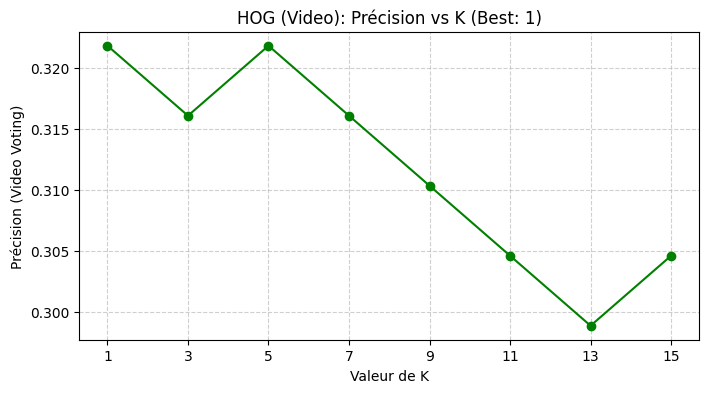

-> Meilleur K retenu pour HOG : 1

--- Recherche du meilleur K pour ResNet (Video Voting) ---
Test de K=1... Accuracy: 0.7701
Test de K=3... Accuracy: 0.7874
Test de K=5... Accuracy: 0.7701
Test de K=7... Accuracy: 0.7701
Test de K=9... Accuracy: 0.7759
Test de K=11... Accuracy: 0.7816
Test de K=13... Accuracy: 0.7989
Test de K=15... Accuracy: 0.8161


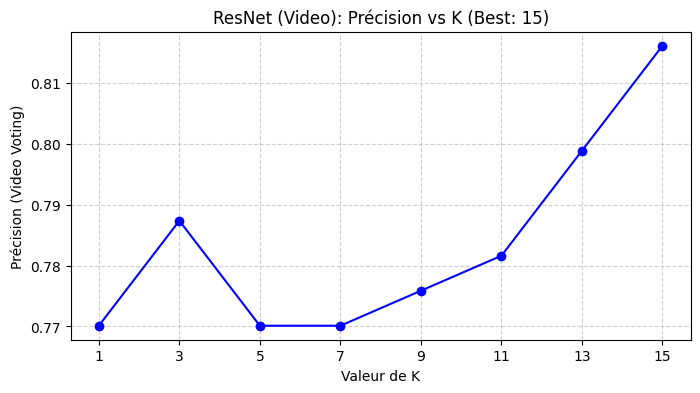

-> Meilleur K retenu pour ResNet : 15


In [ ]:
k_range = [1, 3, 5, 7, 9, 11, 13, 15]

def compute_accuracy_from_predictions(predictions):
    correct = 0
    total = 0
    for true_class, pred_list in predictions.items():
        for pred in pred_list:
            if pred == true_class:
                correct += 1
            total += 1
    return correct / total if total > 0 else 0

def select_best_k_hog_video(k_values):
    print("--- Recherche du meilleur K pour HOG (Video Voting) ---")
    accuracies = []
    
    for k in k_values:
        print(f"Test de K={k}...", end=" ")
        
        video_predictions = predict_videos_from_frames(
            hog_test_features_dataset, 
            test_manifest, 
            lambda fd: classify_frame_knn(fd, hog_reference_features_dataset, k=k)
        )
        
        acc = compute_accuracy_from_predictions(video_predictions)
        accuracies.append(acc)
        print(f"Accuracy: {acc:.4f}")
    
    best_acc = max(accuracies)
    best_k = k_values[accuracies.index(best_acc)]
    
    plt.figure(figsize=(8, 4))
    plt.plot(k_values, accuracies, marker='o', color='green', linestyle='-', label='HOG Accuracy')
    plt.title(f'HOG (Video): Précision vs K (Best: {best_k})')
    plt.xlabel('Valeur de K')
    plt.ylabel('Précision (Video Voting)')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.xticks(k_values)
    plt.show()
    
    return best_k

def select_best_k_resnet_video(k_values):
    print("\n--- Recherche du meilleur K pour ResNet (Video Voting) ---")
    accuracies = []
    
    for k in k_values:
        print(f"Test de K={k}...", end=" ")
        
        video_predictions = predict_videos_from_frames(
            resnet_test_features_dataset, 
            test_manifest, 
            lambda fd: classify_frame_knn(fd, resnet_reference_features_dataset, k=k)
        )
        
        acc = compute_accuracy_from_predictions(video_predictions)
        accuracies.append(acc)
        print(f"Accuracy: {acc:.4f}")
    
    best_acc = max(accuracies)
    best_k = k_values[accuracies.index(best_acc)]
    
    plt.figure(figsize=(8, 4))
    plt.plot(k_values, accuracies, marker='o', color='blue', linestyle='-', label='ResNet Accuracy')
    plt.title(f'ResNet (Video): Précision vs K (Best: {best_k})')
    plt.xlabel('Valeur de K')
    plt.ylabel('Précision (Video Voting)')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.xticks(k_values)
    plt.show()
    
    return best_k

# Optimisation pour HOG
best_k_hog = select_best_k_hog_video(k_range)
print(f"-> Meilleur K retenu pour HOG : {best_k_hog}")

# Optimisation pour ResNet
best_k_resnet = select_best_k_resnet_video(k_range)
print(f"-> Meilleur K retenu pour ResNet : {best_k_resnet}")
            


----------------------------------------------------------------
Evaluation: HOG + Centroid (Video Voting)
                  precision    recall  f1-score   support

          Biking       0.57      0.89      0.69        37
HandstandPushups       0.32      0.48      0.39        33
    PlayingCello       0.30      0.17      0.22        47
   PlayingViolin       0.52      0.43      0.47        28
         PushUps       0.38      0.21      0.27        29

        accuracy                           0.43       174
       macro avg       0.42      0.44      0.41       174
    weighted avg       0.41      0.43      0.40       174



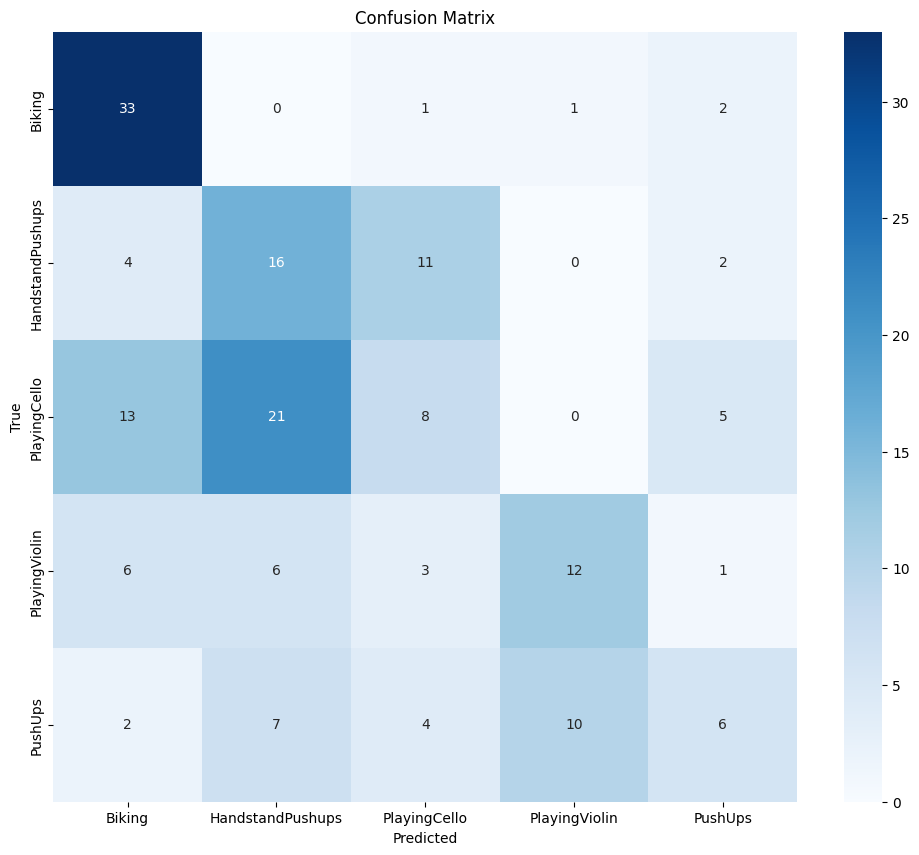

----------------------------------------------------------------
Evaluation: ResNet + Centroid (Video Voting)
                  precision    recall  f1-score   support

          Biking       1.00      1.00      1.00        37
HandstandPushups       0.86      0.73      0.79        33
    PlayingCello       1.00      0.85      0.92        47
   PlayingViolin       0.82      1.00      0.90        28
         PushUps       0.71      0.86      0.78        29

        accuracy                           0.89       174
       macro avg       0.88      0.89      0.88       174
    weighted avg       0.90      0.89      0.89       174



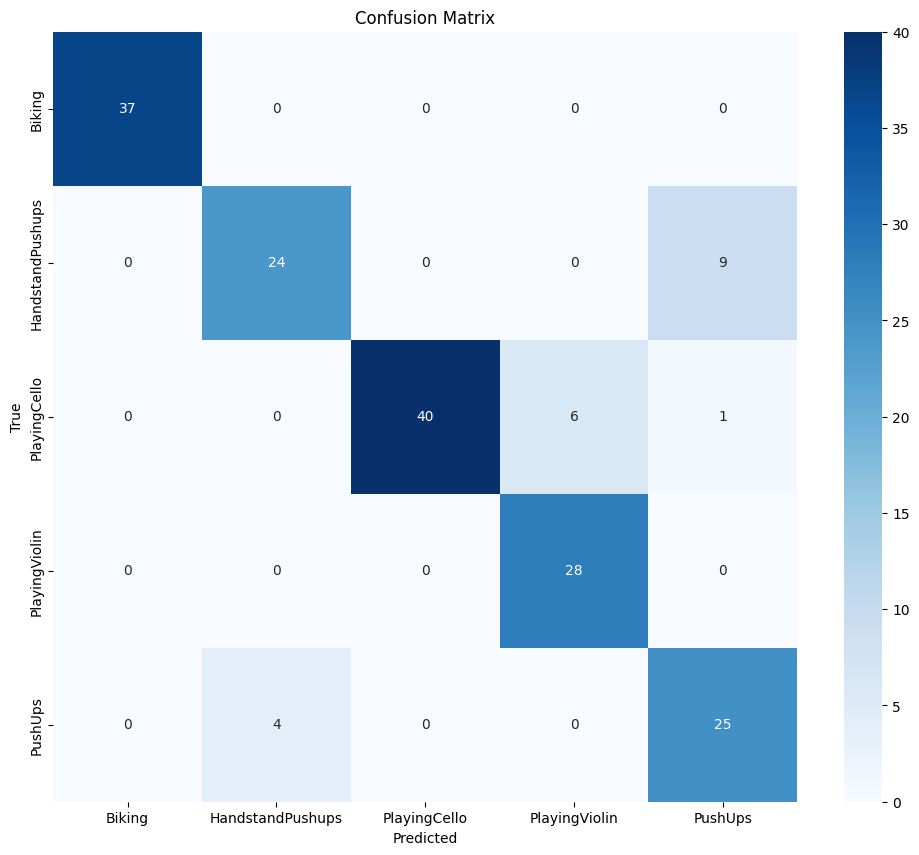

----------------------------------------------------------------
Evaluation: HOG + KNN (Video Voting)
                  precision    recall  f1-score   support

          Biking       0.29      0.95      0.45        37
HandstandPushups       1.00      0.03      0.06        33
    PlayingCello       0.67      0.04      0.08        47
   PlayingViolin       0.00      0.00      0.00        28
         PushUps       0.38      0.62      0.47        29

        accuracy                           0.32       174
       macro avg       0.47      0.33      0.21       174
    weighted avg       0.50      0.32      0.21       174



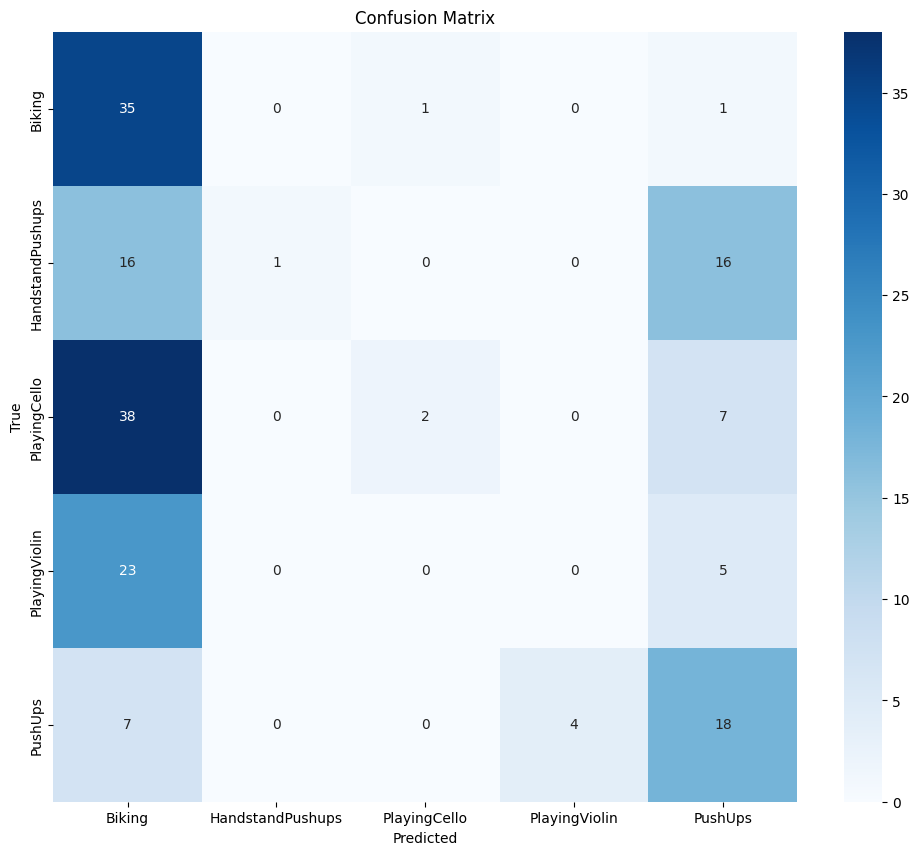

----------------------------------------------------------------
Evaluation: ResNet + KNN (Video Voting)
                  precision    recall  f1-score   support

          Biking       0.84      1.00      0.91        37
HandstandPushups       0.63      0.67      0.65        33
    PlayingCello       0.98      0.85      0.91        47
   PlayingViolin       0.79      0.96      0.87        28
         PushUps       0.80      0.55      0.65        29

        accuracy                           0.82       174
       macro avg       0.81      0.81      0.80       174
    weighted avg       0.82      0.82      0.81       174



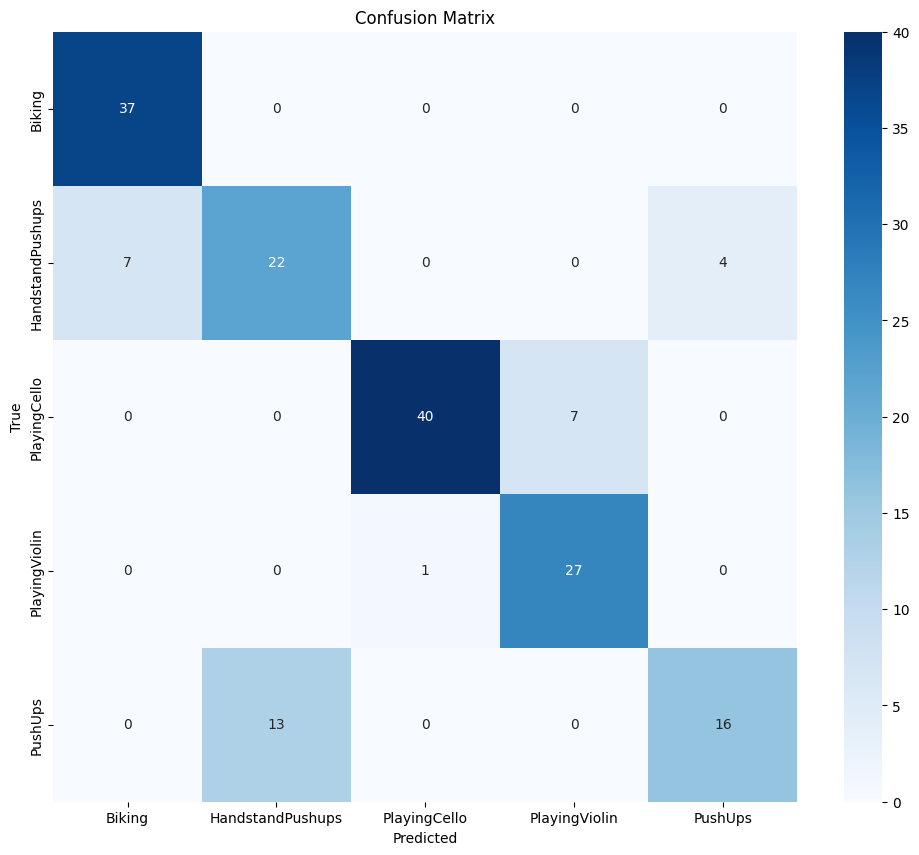

In [ ]:
print("----------------------------------------------------------------")
print("Evaluation: HOG + Centroid (Video Voting)")
video_predictions_hog_centroid = predict_videos_from_frames(
    hog_test_features_dataset, 
    test_manifest, 
    lambda fd: classify_frame_centroid(fd, class_hog_averages_reference)
)
evaluate_classification(video_predictions_hog_centroid)

print("----------------------------------------------------------------")
print("Evaluation: ResNet + Centroid (Video Voting)")
video_predictions_resnet_centroid = predict_videos_from_frames(
    resnet_test_features_dataset, 
    test_manifest, 
    lambda fd: classify_frame_centroid(fd, class_resnet_averages_reference)
)
evaluate_classification(video_predictions_resnet_centroid)

print("----------------------------------------------------------------")
print("Evaluation: HOG + KNN (Video Voting)")
# on prend k = 5 car il fait partie des meilleurs et permet un meilleur compromis
video_predictions_hog_knn = predict_videos_from_frames(
    hog_test_features_dataset, 
    test_manifest, 
    lambda fd: classify_frame_knn(fd, hog_reference_features_dataset, k=5) 
)
evaluate_classification(video_predictions_hog_knn)

print("----------------------------------------------------------------")
print("Evaluation: ResNet + KNN (Video Voting)")
video_predictions_resnet_knn = predict_videos_from_frames(
    resnet_test_features_dataset, 
    test_manifest, 
    lambda fd: classify_frame_knn(fd, resnet_reference_features_dataset, k=15)
)
evaluate_classification(video_predictions_resnet_knn)

In [28]:

## augmente la luminosité de l'image
def augment_brightness(image, value=50):
    # on passe en HSV pour modifier la composante V (Value) (plus simple)
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    h, s, v = cv2.split(hsv)
    
    v = cv2.add(v, value)
    
    final_hsv = cv2.merge((h, s, v))
    return cv2.cvtColor(final_hsv, cv2.COLOR_HSV2BGR)

## augmente geometriquement 
def augment_rotation(image):
    return cv2.rotate(image, cv2.ROTATE_90_CLOCKWISE)


In [29]:
test_frames_bright = {}
test_frames_rot = {}

for class_name, frames in test_frame_dataset.items():
    test_frames_bright[class_name] = [augment_brightness(f, value=-50) for f in frames]
    test_frames_rot[class_name] = [augment_rotation(f) for f in frames]

In [30]:

hog_test_bright = extract_hog_features_for_dataset(test_frames_bright)
hog_test_rot = extract_hog_features_for_dataset(test_frames_rot)

resnet_test_bright = compute_resnet_features(test_frames_bright, model, preprocess)
resnet_test_rot = compute_resnet_features(test_frames_rot, model, preprocess)

Computing ResNet Features: 100%|██████████| 5/5 [00:59<00:00, 11.82s/it]



Evaluation: HOG - Centroid - Luminosité
                  precision    recall  f1-score   support

          Biking       0.65      0.92      0.76        37
HandstandPushups       0.32      0.52      0.40        33
    PlayingCello       0.22      0.04      0.07        47
   PlayingViolin       0.49      0.61      0.54        28
         PushUps       0.40      0.34      0.37        29

        accuracy                           0.46       174
       macro avg       0.42      0.49      0.43       174
    weighted avg       0.40      0.46      0.41       174



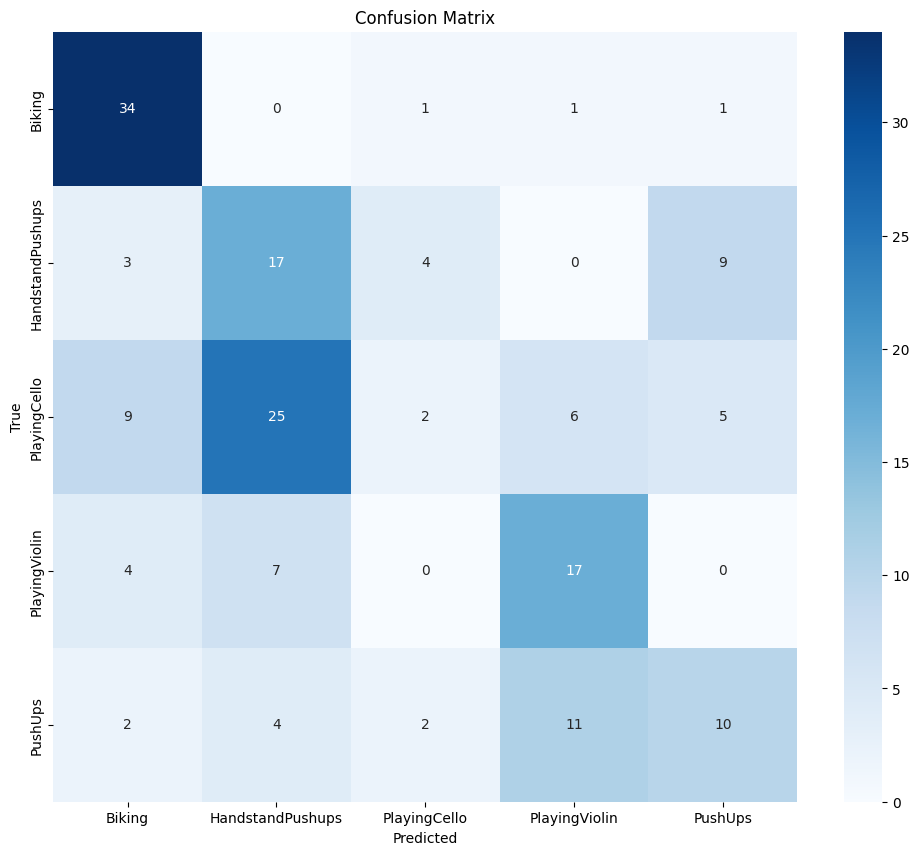


Evaluation: HOG - Centroid - Rotation
                  precision    recall  f1-score   support

          Biking       0.25      0.57      0.34        37
HandstandPushups       0.22      0.45      0.30        33
    PlayingCello       0.00      0.00      0.00        47
   PlayingViolin       0.40      0.14      0.21        28
         PushUps       0.14      0.03      0.06        29

        accuracy                           0.24       174
       macro avg       0.20      0.24      0.18       174
    weighted avg       0.18      0.24      0.17       174



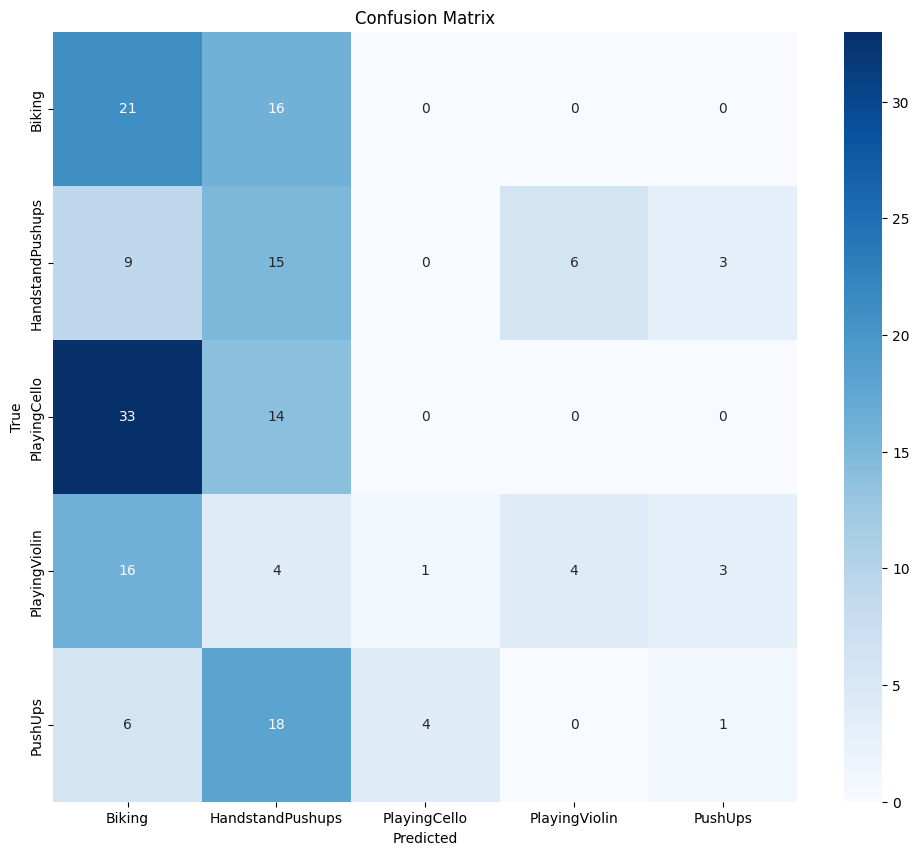


Evaluation: ResNet - Centroid - Luminosité
                  precision    recall  f1-score   support

          Biking       1.00      1.00      1.00        37
HandstandPushups       0.73      0.73      0.73        33
    PlayingCello       1.00      0.85      0.92        47
   PlayingViolin       0.80      1.00      0.89        28
         PushUps       0.69      0.69      0.69        29

        accuracy                           0.86       174
       macro avg       0.84      0.85      0.85       174
    weighted avg       0.86      0.86      0.86       174



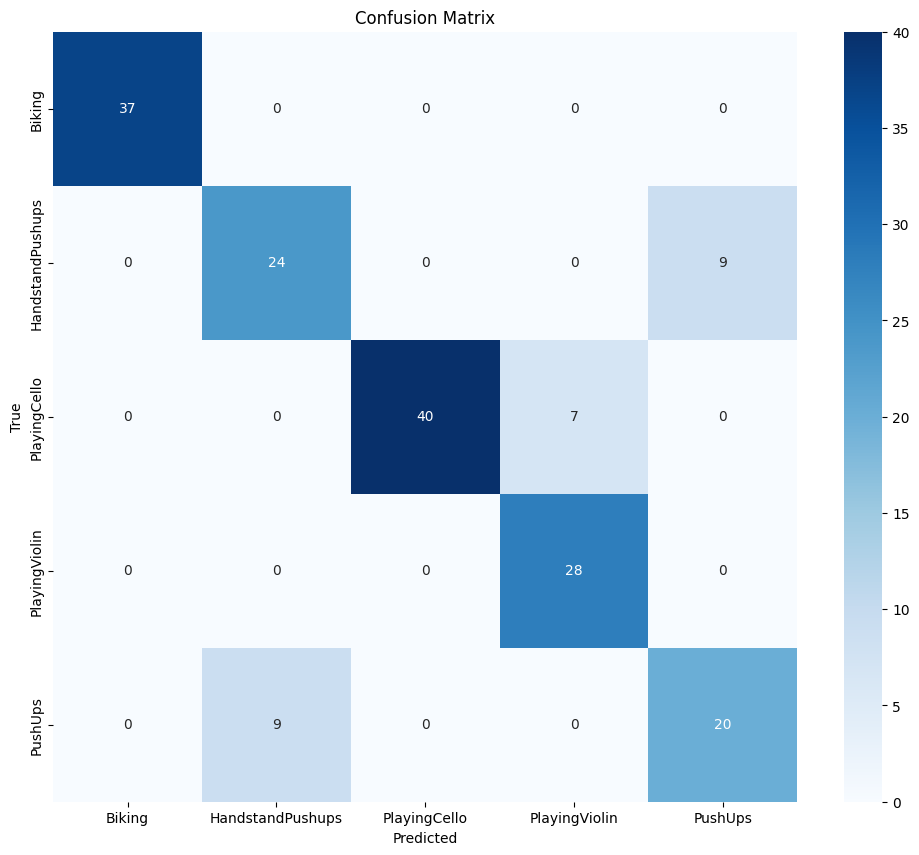


Evaluation: ResNet - Centroid - Rotation
                  precision    recall  f1-score   support

          Biking       1.00      0.95      0.97        37
HandstandPushups       0.48      0.48      0.48        33
    PlayingCello       1.00      0.74      0.85        47
   PlayingViolin       0.85      0.82      0.84        28
         PushUps       0.30      0.45      0.36        29

        accuracy                           0.70       174
       macro avg       0.73      0.69      0.70       174
    weighted avg       0.76      0.70      0.72       174



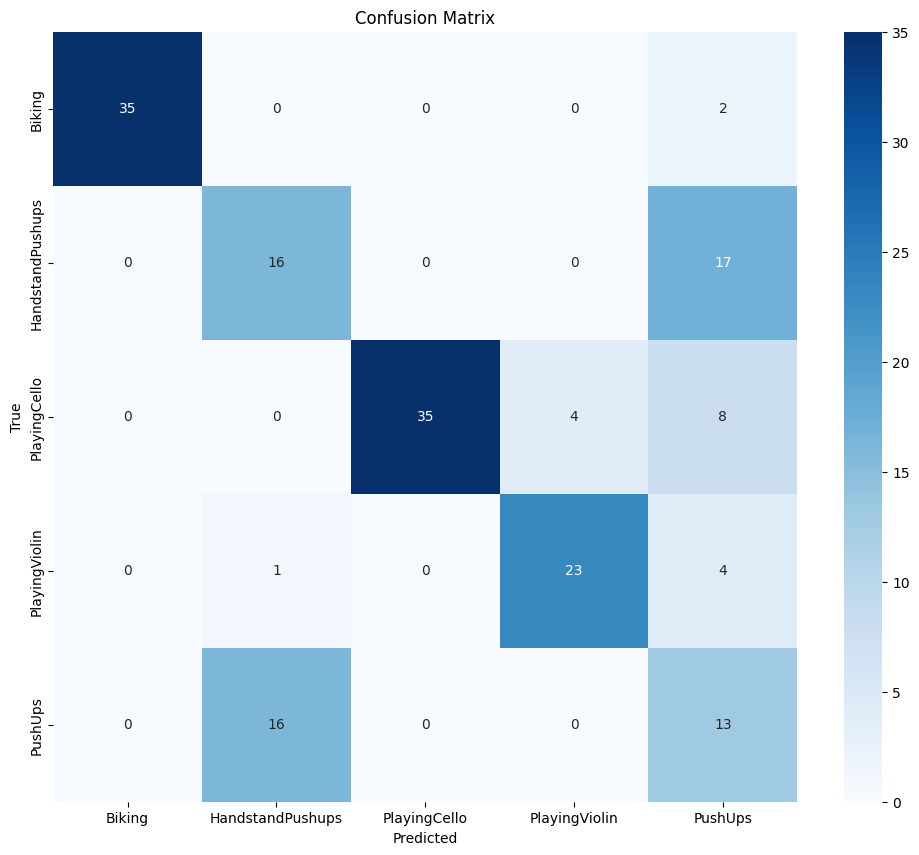


Evaluation: HOG - kNN - Luminosité
                  precision    recall  f1-score   support

          Biking       0.32      0.95      0.48        37
HandstandPushups       0.00      0.00      0.00        33
    PlayingCello       1.00      0.02      0.04        47
   PlayingViolin       0.50      0.39      0.44        28
         PushUps       0.29      0.41      0.34        29

        accuracy                           0.34       174
       macro avg       0.42      0.35      0.26       174
    weighted avg       0.47      0.34      0.24       174



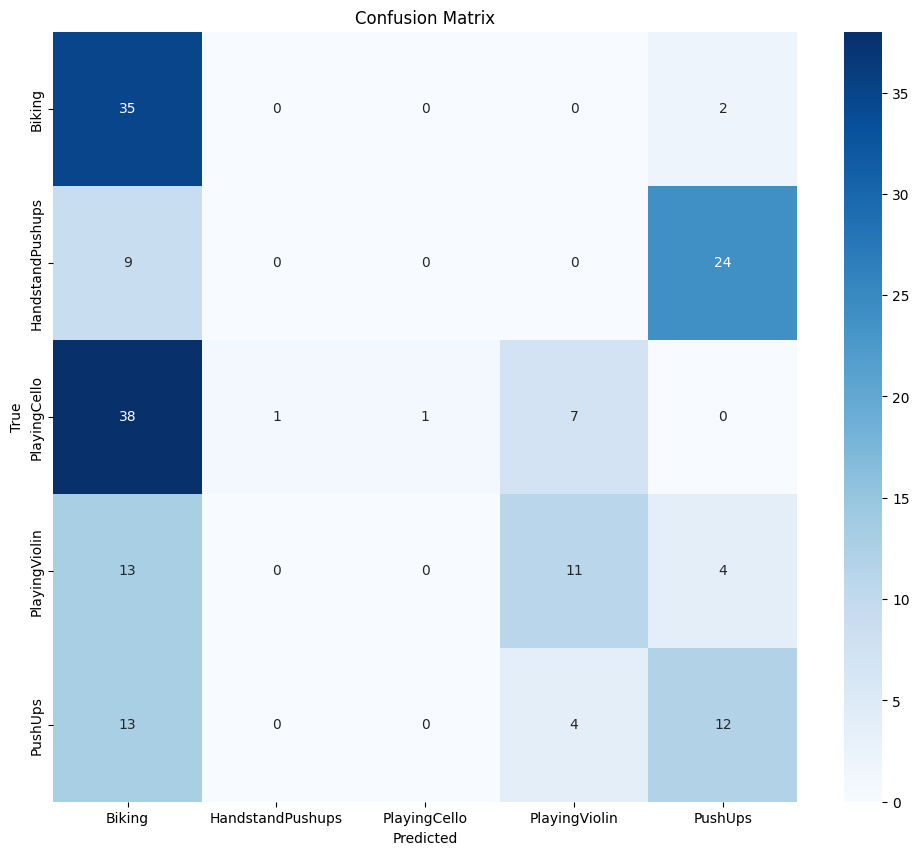


Evaluation: HOG - kNN - Rotation
                  precision    recall  f1-score   support

          Biking       0.23      0.95      0.38        37
HandstandPushups       0.00      0.00      0.00        33
    PlayingCello       0.00      0.00      0.00        47
   PlayingViolin       0.00      0.00      0.00        28
         PushUps       0.12      0.10      0.11        29

        accuracy                           0.22       174
       macro avg       0.07      0.21      0.10       174
    weighted avg       0.07      0.22      0.10       174



/Users/gaspardjuillet/Library/Mobile Documents/com~apple~CloudDocs/Poly_Cours/H_2026/Computer_Vision/Computer_Vision_TP1/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/gaspardjuillet/Library/Mobile Documents/com~apple~CloudDocs/Poly_Cours/H_2026/Computer_Vision/Computer_Vision_TP1/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/gaspardjuillet/Library/Mobile Documents/com~apple~CloudDocs/Poly_Cours/H_2026/Computer_Vision/Computer_Vision_TP1/.venv

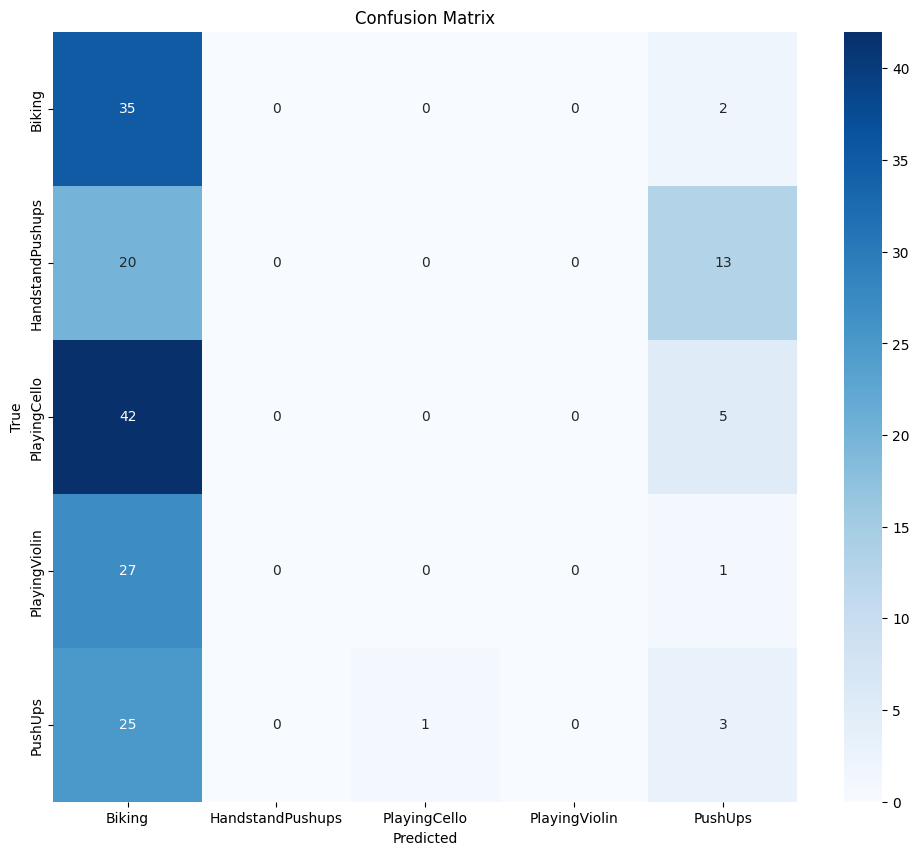


Evaluation: ResNet - kNN - Luminosité
                  precision    recall  f1-score   support

          Biking       0.86      1.00      0.93        37
HandstandPushups       0.62      0.61      0.62        33
    PlayingCello       0.98      0.89      0.93        47
   PlayingViolin       0.82      0.96      0.89        28
         PushUps       0.70      0.55      0.62        29

        accuracy                           0.82       174
       macro avg       0.80      0.80      0.79       174
    weighted avg       0.81      0.82      0.81       174



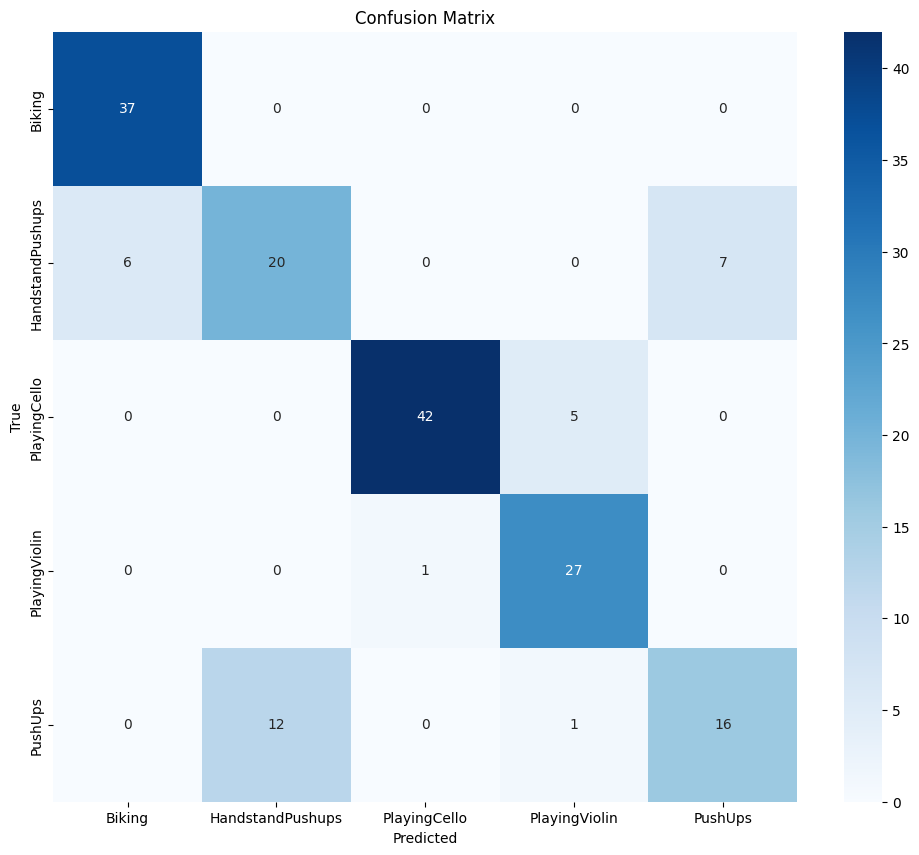


Evaluation: ResNet - kNN - Rotation
                  precision    recall  f1-score   support

          Biking       0.77      1.00      0.87        37
HandstandPushups       0.25      0.18      0.21        33
    PlayingCello       0.97      0.81      0.88        47
   PlayingViolin       0.74      0.93      0.83        28
         PushUps       0.25      0.24      0.25        29

        accuracy                           0.66       174
       macro avg       0.60      0.63      0.61       174
    weighted avg       0.64      0.66      0.64       174



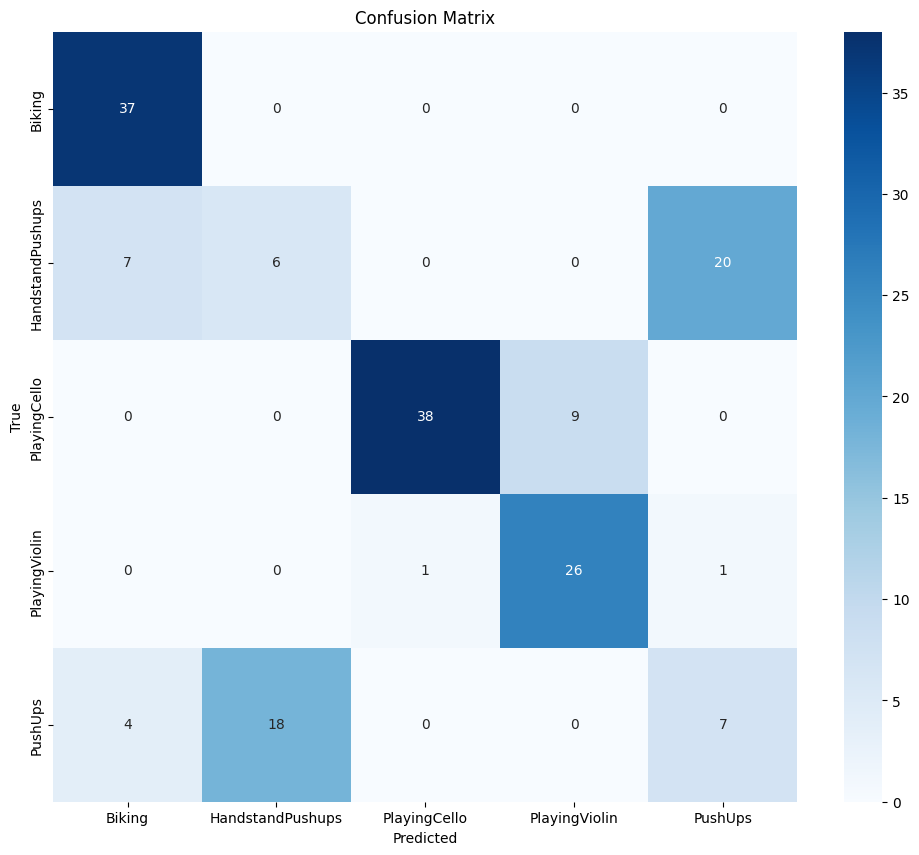

In [31]:

def run_robustness_eval(features, model_name, condition, predictor_func):
    print(f"\nEvaluation: {model_name} - {condition}")
    predictions = predict_videos_from_frames(features, test_manifest, predictor_func)
    evaluate_classification(predictions)


hog_centroid_predictor = lambda fd: classify_frame_centroid(fd, class_hog_averages_reference)
run_robustness_eval(hog_test_bright, "HOG - Centroid", "Luminosité", hog_centroid_predictor)
run_robustness_eval(hog_test_rot, "HOG - Centroid", "Rotation", hog_centroid_predictor)

resnet_centroid_predictor = lambda fd: classify_frame_centroid(fd, class_resnet_averages_reference)
run_robustness_eval(resnet_test_bright, "ResNet - Centroid", "Luminosité", resnet_centroid_predictor)
run_robustness_eval(resnet_test_rot, "ResNet - Centroid", "Rotation", resnet_centroid_predictor)

hog_knn_predictor = lambda fd: classify_frame_knn(fd, hog_reference_features_dataset, k=5)
run_robustness_eval(hog_test_bright, "HOG - kNN", "Luminosité", hog_knn_predictor)
run_robustness_eval(hog_test_rot, "HOG - kNN", "Rotation", hog_knn_predictor)

resnet_knn_predictor = lambda fd: classify_frame_knn(fd, resnet_reference_features_dataset, k=5)
run_robustness_eval(resnet_test_bright, "ResNet - kNN", "Luminosité", resnet_knn_predictor)
run_robustness_eval(resnet_test_rot, "ResNet - kNN", "Rotation", resnet_knn_predictor)

### Étude du meilleur k (k-NN) pour ResNet

### Mesure du temps de traitement pour chaque méthode

Starting performance measurement...

Measuring: HOG + Centroid


Extracting HOG features: 100%|██████████| 5/5 [00:22<00:00,  4.41s/it]


Time: 25.70s

Measuring: HOG + kNN


Extracting HOG features: 100%|██████████| 5/5 [00:20<00:00,  4.11s/it]


Time: 34.67s

Measuring: ResNet + Centroid


Computing ResNet Features: 100%|██████████| 5/5 [00:10<00:00,  2.18s/it]


Time: 13.05s

Measuring: ResNet + kNN


Computing ResNet Features: 100%|██████████| 5/5 [00:10<00:00,  2.00s/it]


Time: 21.38s


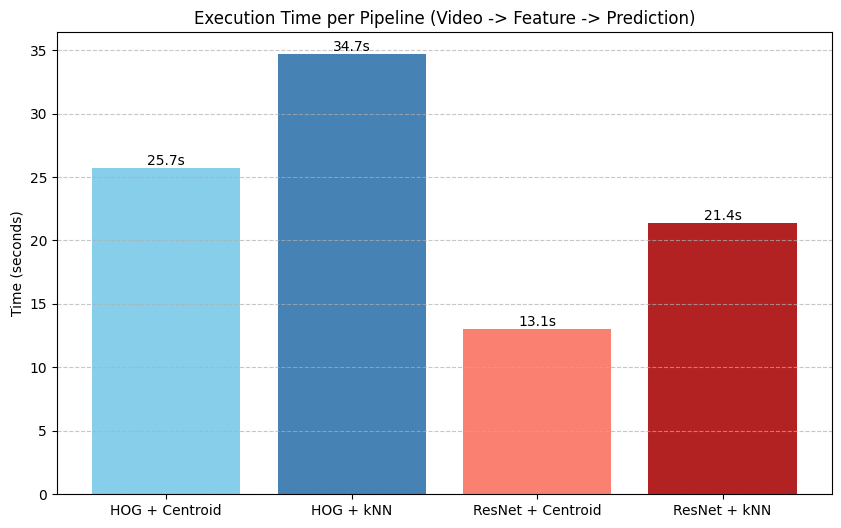

In [ ]:
import time
import matplotlib.pyplot as plt

pipeline_times = {}

print("Starting performance measurement...")

# HOG + Centroid
print("\nMeasuring: HOG + Centroid")
start_time = time.time()

frames, manifest = extract_frames_from_video_set(test_path_set, frame_rate=1)
features = extract_hog_features_for_dataset(frames)
_ = predict_videos_from_frames(
    features, 
    manifest, 
    lambda fd: classify_frame_centroid(fd, class_hog_averages_reference)
)

end_time = time.time()
pipeline_times["HOG + Centroid"] = end_time - start_time
print(f"Time: {pipeline_times['HOG + Centroid']:.2f}s")


# HOG + kNN
print("\nMeasuring: HOG + kNN")
start_time = time.time()

frames, manifest = extract_frames_from_video_set(test_path_set, frame_rate=1)
features = extract_hog_features_for_dataset(frames)
_ = predict_videos_from_frames(
    features, 
    manifest, 
    lambda fd: classify_frame_knn(fd, hog_reference_features_dataset, k=5)
)

end_time = time.time()
pipeline_times["HOG + kNN"] = end_time - start_time
print(f"Time: {pipeline_times['HOG + kNN']:.2f}s")


# ResNet + Centroid
print("\nMeasuring: ResNet + Centroid")
start_time = time.time()

frames, manifest = extract_frames_from_video_set(test_path_set, frame_rate=1)
features = compute_resnet_features(frames, model, preprocess)
_ = predict_videos_from_frames(
    features, 
    manifest, 
    lambda fd: classify_frame_centroid(fd, class_resnet_averages_reference)
)

end_time = time.time()
pipeline_times["ResNet + Centroid"] = end_time - start_time
print(f"Time: {pipeline_times['ResNet + Centroid']:.2f}s")


# ResNet + kNN
print("\nMeasuring: ResNet + kNN")
start_time = time.time()

frames, manifest = extract_frames_from_video_set(test_path_set, frame_rate=1)
features = compute_resnet_features(frames, model, preprocess)
_ = predict_videos_from_frames(
    features, 
    manifest, 
    lambda fd: classify_frame_knn(fd, resnet_reference_features_dataset, k=5)
)

end_time = time.time()
pipeline_times["ResNet + kNN"] = end_time - start_time
print(f"Time: {pipeline_times['ResNet + kNN']:.2f}s")

# Visualization
plt.figure(figsize=(10, 6))
bars = plt.bar(pipeline_times.keys(), pipeline_times.values(), color=['skyblue', 'steelblue', 'salmon', 'firebrick'])
plt.title("Execution Time per Pipeline (Video -> Feature -> Prediction)")
plt.ylabel("Time (seconds)")
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add value labels
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, f'{yval:.1f}s', va='bottom', ha='center')

plt.show()